# Dave's email dated 2023-08-31
Anything you can do to limit the number of entries I need to check manually would be awesome. I'm very happy to do the rest by hand, particularly sorting through the "product" annotations. 

I've attached a csv file with the annotations. There are up to 7 different annotations per "gene". They are: 
"OV986001.1 CDS" = current CDS annotations that I have not altered
"OV986001.1 exon" = current exon annotations that I have not altered
AM181176 = original Silby CDS annotations
REFSEQ = annotations from the REFSEQ version of the Silby genome NC_012660
JAIOKN = annotations from a different version of the SBW25 genome
NZ_JAIOKW = annotations from yet another different version of the SBW25 genome
PROKKA = de novo annotation I made using PROKKA (prodigal)


The things I would love to get (in order of what I imagine is feasability):

1. Regions that have identical annotations across all 7. These don't need any further examination.
2. Regions that are annotated in all genomes but have different minima or maxima. 
3. Regions that are only annotated in some versions - particularly regions that are not annotated in "OV986001.1 exon".

In the end, I want to make a table that has the following information for each gene (in a single row):

1. PFLU_XXXX (if available) - I only care about the other annotations if there is no PFLU number
2. PFLU_RSXXXXX (if available) - I'd like to have both the PFLU number and the REFSEQ number
3. minimum
4. maximum
5. gene name or gene_synonym (not exon, or CDS, or CAI numbers bit rather dnaA or recF)
6. product = something like "chromosomal replication initiator protein DnaA". I have no interest in "hypothetical protein" or "conserved hypothetical protein". Maybe they could be ignored. There will usually be multiple different annotations for each gene. If there were a way to list them all in a single row. That would be great. 



# Load and cleanup data

In [52]:
import pandas
import numpy
import matplotlib
from matplotlib import pyplot

In [31]:
data = pandas.read_csv('annotations_DR_20230831.csv')

In [55]:
len(data)

42222

In [32]:
data.head(20)

Name             Type Minimum Maximum Length Direction  \
0   CAI2794342.1   OV986001.1 CDS       1    1506   1506   forward   
1       dnaA CDS         AM181176       1    1506   1506   forward   
2           exon  OV986001.1 exon       1    1506   1506   forward   
3       dnaA CDS           REFSEQ       1    1506   1506   forward   
4       dnaA CDS           JAIOKN      <1    1506  >1506   forward   
5       dnaA CDS        NZ_JAIOKW      <1    1506  >1506   forward   
6            CDS       PROKKA_CDS       7    1506   1500   forward   
7   CAI2794343.1   OV986001.1 CDS    1545    2648   1104   forward   
8       dnaN CDS         AM181176    1545    2648   1104   forward   
9           exon  OV986001.1 exon    1545    2648   1104   forward   
10           CDS       PROKKA_CDS    1545    2648   1104   forward   
11      dnaN CDS           REFSEQ    1545    2648   1104   forward   
12      dnaN CDS           JAIOKN    1545    2648   1104   forward   
13      dnaN CDS        NZ_JAIOKW    1545    2648   1104   forward   
14  CAI2794344.1   OV986001.1 CDS    2669    3772   1104   forward   
15      recF CDS         AM181176    2669    3772   1104   forward   
16          exon  OV986001.1 exon    2669    3772   1104   forward   
17           CDS       PROKKA_CDS    2669    3772   1104   forward   
18      recF CDS           REFSEQ    2669    3772   1104   forward   
19      recF CDS           JAIOKN    2669    3772   1104   forward   

                                           product gene_synonym      locus_tag  
0   Chromosomal replication initiator protein DnaA          NaN      PFLU_0001  
1   chromosomal replication initiator protein DnaA          NaN      PFLU_0001  
2                                              NaN          NaN      PFLU_0001  
3   chromosomal replication initiator protein DnaA          NaN   PFLU_RS00005  
4   chromosomal replication initiator protein DnaA          NaN  K7400_RS04265  
5   chromosomal replication initiator protein DnaA          NaN  K7431_RS08480  
6   Chromosomal replication initiator protein DnaA   dnaA; dnaA            NaN  
7                               Beta sliding clamp          NaN      PFLU_0002  
8                   DNA polymerase III, beta chain          NaN      PFLU_0002  
9                                              NaN          NaN      PFLU_0002  
10                              Beta sliding clamp   dnaN; dnaN            NaN  
11                 DNA polymerase III subunit beta          NaN   PFLU_RS00010  
12                 DNA polymerase III subunit beta          NaN  K7400_RS04270  
13                 DNA polymerase III subunit beta          NaN  K7431_RS08485  
14         DNA replication and repair protein RecF          NaN      PFLU_0003  
15         DNA replication and repair protein RecF          NaN      PFLU_0003  
16                                             NaN          NaN      PFLU_0003  
17         DNA replication and repair protein RecF   recF; recF            NaN  
18             DNA replication/repair protein RecF          NaN   PFLU_RS00015  
19             DNA replication/repair protein RecF          NaN  K7400_RS04275

## fix start end end positions
Some locations are denoted "<N" or ">N". I boldly assume that N is the actual coordinate, so remove the "</>" characters.

In [37]:
data['Minimum'] = uniqueMinimum.str.replace(">", "")
data['Minimum'] = data.Minimum.str.replace("<", "")
data['Maximum'] = data.Maximum.str.replace(">", "")
data['Maximum'] = data.Maximum.str.replace("<", "")
data['Length'] = data.Length.str.replace(">", "")
data['Length'] = data.Length.str.replace("<", "")

data['Minimum'] = data.Minimum.astype(int)
data['Maximum'] = data.Maximum.astype(int)
data['Length'] = data.Length.astype(int)

In [428]:
unique_pflu_locus_tags = set([m.group(0) for m in [re.search(r"PFLU_[0-9]{4}", lt) for lt in data['locus_tag'].astype(str)] if m is not None])

In [429]:
len(unique_pflu_locus_tags)

6054

In [321]:
for idx in data.index:
    start, stop, strand = data.loc[idx,['Minimum', 'Maximum', 'Direction']].values
    overlaps = data[((((data.Minimum >= start) & (data.Minimum <= stop)) | \
                                    ((data.Maximum >= start) & (data.Maximum <= stop))) & (data.Direction == strand))].index
    
    data.loc[idx, 'overlaps']= ','.join([str(ov) for ov in sorted(overlaps)])

In [322]:
data.head(20)

Name             Type  Minimum  Maximum  Length Direction  \
0   CAI2794342.1   OV986001.1 CDS        1     1506    1506   forward   
1       dnaA CDS         AM181176        1     1506    1506   forward   
2           exon  OV986001.1 exon        1     1506    1506   forward   
3       dnaA CDS           REFSEQ        1     1506    1506   forward   
4       dnaA CDS           JAIOKN        1     1506    1506   forward   
5       dnaA CDS        NZ_JAIOKW        1     1506    1506   forward   
6            CDS       PROKKA_CDS        7     1506    1500   forward   
7   CAI2794343.1   OV986001.1 CDS     1545     2648    1104   forward   
8       dnaN CDS         AM181176     1545     2648    1104   forward   
9           exon  OV986001.1 exon     1545     2648    1104   forward   
10           CDS       PROKKA_CDS     1545     2648    1104   forward   
11      dnaN CDS           REFSEQ     1545     2648    1104   forward   
12      dnaN CDS           JAIOKN     1545     2648    1104   forward   
13      dnaN CDS        NZ_JAIOKW     1545     2648    1104   forward   
14  CAI2794344.1   OV986001.1 CDS     2669     3772    1104   forward   
15      recF CDS         AM181176     2669     3772    1104   forward   
16          exon  OV986001.1 exon     2669     3772    1104   forward   
17           CDS       PROKKA_CDS     2669     3772    1104   forward   
18      recF CDS           REFSEQ     2669     3772    1104   forward   
19      recF CDS           JAIOKN     2669     3772    1104   forward   

                                           product gene_synonym  \
0   Chromosomal replication initiator protein DnaA          NaN   
1   chromosomal replication initiator protein DnaA          NaN   
2                                              NaN          NaN   
3   chromosomal replication initiator protein DnaA          NaN   
4   chromosomal replication initiator protein DnaA          NaN   
5   chromosomal replication initiator protein DnaA          NaN   
6   Chromosomal replication initiator protein DnaA   dnaA; dnaA   
7                               Beta sliding clamp          NaN   
8                   DNA polymerase III, beta chain          NaN   
9                                              NaN          NaN   
10                              Beta sliding clamp   dnaN; dnaN   
11                 DNA polymerase III subunit beta          NaN   
12                 DNA polymerase III subunit beta          NaN   
13                 DNA polymerase III subunit beta          NaN   
14         DNA replication and repair protein RecF          NaN   
15         DNA replication and repair protein RecF          NaN   
16                                             NaN          NaN   
17         DNA replication and repair protein RecF   recF; recF   
18             DNA replication/repair protein RecF          NaN   
19             DNA replication/repair protein RecF          NaN   

        locus_tag  Midpoint  mpidx              overlaps  
0       PFLU_0001       753      0         0,1,2,3,4,5,6  
1       PFLU_0001       753      0         0,1,2,3,4,5,6  
2       PFLU_0001       753      0         0,1,2,3,4,5,6  
3    PFLU_RS00005       753      0         0,1,2,3,4,5,6  
4   K7400_RS04265       753      0         0,1,2,3,4,5,6  
5   K7431_RS08480       753      0         0,1,2,3,4,5,6  
6             NaN       756      1         0,1,2,3,4,5,6  
7       PFLU_0002      2096      2     7,8,9,10,11,12,13  
8       PFLU_0002      2096      2     7,8,9,10,11,12,13  
9       PFLU_0002      2096      2     7,8,9,10,11,12,13  
10            NaN      2096      2     7,8,9,10,11,12,13  
11   PFLU_RS00010      2096      2     7,8,9,10,11,12,13  
12  K7400_RS04270      2096      2     7,8,9,10,11,12,13  
13  K7431_RS08485      2096      2     7,8,9,10,11,12,13  
14      PFLU_0003      3220      3  14,15,16,17,18,19,20  
15      PFLU_0003      3220      3  14,15,16,17,18,19,20  
16      PFLU_0003      3220      3  14,15,16,17,18,19,20  
17      

In [323]:
overlap_groups = data.groupby('overlaps')

In [324]:
len(overlap_groups)

6094

## Cluster all records based on their coordinates.

In [43]:
data['Midpoint'] = (data.Minimum + data.Maximum)//2

In [47]:
midpoint_groups = data.groupby('Midpoint')

In [180]:
### Histogram over cluster sizes.

In [50]:
cluster_size = [len(grp[1]) for grp in midpoint_groups]

(array([ 725.,  386.,    0., 1087.,    0.,  857.,  276.,    0.,  244.,
        4456.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

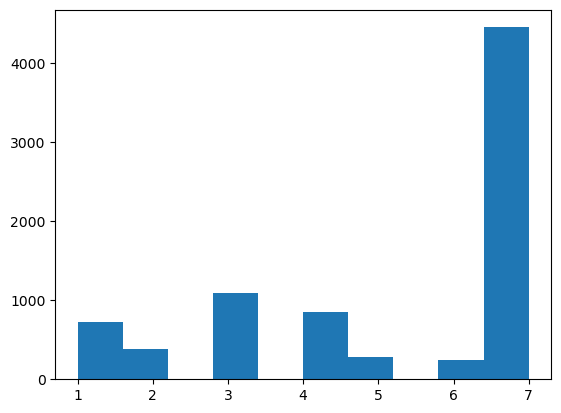

In [53]:
pyplot.hist(cluster_size)

In [79]:
midpoint_group_lengths = data.groupby('Midpoint').apply(len)

In [81]:
midpoint_group_lengths[midpoint_group_lengths<7]

Midpoint
753        6
756        1
7762       3
7774       1
7778       3
          ..
6721144    3
6721462    4
6721465    2
6721492    1
6721748    6
Length: 3575, dtype: int64

ok, so let's analyse cluster by cluster without merging any clusters for now.

In [117]:
unique_types = data.Type.unique()

In [119]:
import re

### Main loop.
- Loop over all groups
- In each group, concat start and stop coordinates
- Then concatenate the products but filter out 'hypothetical'. Separate products by "|"
- Same for gene synonyms, check abcD pattern
- get pflu and refseq locus tags by matchi pflu_XXXX and pflu_rsXXXXX patterns.
- Indicate which of the 7 original annotations is represented in this group


In [356]:
records=[]

for i,grp in enumerate(overlap_groups):
    record = {
        'Minimum': "|".join(set(grp[1].Minimum.astype(str).values)),
        'Maximum': "|".join(set(grp[1].Maximum.astype(str).values)),
        'Direction': grp[1].iloc[0, 5],
    }
 
    
    # Get all products.
    products = set(grp[1]['product'].astype(str).str.lower())
    
    # Filter out "hypothetical"s
    products = [prod for prod in products if re.search("hypothetical", prod) is None]
    products = [prod for prod in products if prod!='nan']
    
    if len(products) == 0:
        products = ['nan']
    
    # Store in record.
    record['product'] = '|'.join(products)
    record['number of diff. annotations'] = len(products)
    
    # Get synonyms
    gene_synonyms =  set(grp[1]['gene_synonym'].astype(str))
    # Retain only proper gene names abcD
    gene_synonyms = [re.search(r'[a-z]{3}[A-Z]{1}', gs) for gs in gene_synonyms ]
    gene_synonyms = [gs.group(0) for gs in gene_synonyms if gs is not None]
   
    # Store in record.
    record['gene_synonyms'] = "|".join(gene_synonyms)
    
    # PFLU_XXXX and PFLU_RSXXXXX locus tags
    locus_tag_pflu = []
    locus_tag_rs = []
    for lt in grp[1].locus_tag.astype(str).values:
        if re.match('^PFLU_[0-9]{4}$', lt) is not None:
            locus_tag_pflu.append(lt)
        elif re.match('^PFLU_RS[0-9]{5}$', lt) is not None:
            locus_tag_rs.append(lt)
    record['locus_tag_pflu'] = "|".join(set(locus_tag_pflu))
    record['locus_tag_rs'] = "|".join(set(locus_tag_rs))
    
    # Indicate origin of this record's data.
    for utype in unique_types:
        if utype in grp[1].Type.values:
            record[utype] = 1
            nor += 1
        else:
            record[utype] = 0
        
    records.append(record)

In [357]:
grouped_records = pandas.DataFrame(data=records)

In [358]:
grouped_records.head(10)

Minimum  Maximum Direction  \
0              1|7     1506   forward   
1  1609089|1609197  1609625   forward   
2          1609664  1610707   forward   
3          1610869  1611033   forward   
4          1611238  1612842   reverse   
5          1613307  1613888   forward   
6          1613921  1614508   forward   
7          1614524  1615486   forward   
8          1615516  1615695   reverse   
9          1615721  1617157   forward   

                                             product  \
0     chromosomal replication initiator protein dnaa   
1                            uncharacterized protein   
2                            uncharacterized protein   
3                                                nan   
4        l-aspartate oxidase|l-aspartate oxidase (ec   
5  rna polymerase sigma-h factor|alternative ecf ...   
6  sigma factor negative regulatory protein|rsea ...   
7  sigma factor regulatory protein precursor|sigm...   
8                                                nan   
9  degq family serine endoprotease|periplasmic se...   

   number of diff. annotations gene_synonyms locus_tag_pflu  locus_tag_rs  \
0                            1          dnaA      PFLU_0001  PFLU_RS00005   
1                            1                    PFLU_1463  PFLU_RS07215   
2                            1                    PFLU_1464  PFLU_RS07220   
3                            1                               PFLU_RS31855   
4                            2          nadB      PFLU_1465  PFLU_RS07225   
5                            4          algU      PFLU_1467  PFLU_RS07230   
6                            3          mucA      PFLU_1468  PFLU_RS07235   
7                            4          mucB      PFLU_1469  PFLU_RS07240   
8                            1                               PFLU_RS31440   
9                            4          degP      PFLU_1471  PFLU_RS07245   

   OV986001.1 CDS  AM181176  OV986001.1 exon  REFSEQ  JAIOKN  NZ_JAIOKW  \
0               1         1                1       1       1          1   
1               1         1                1       1       1          1   
2               1         1                1       1       1          1   
3               0         0                0       1       1          1   
4               1         1                1       1       1          1   
5               1         1                1       1       1          1   
6               1         1                1       1       1          1   
7               1         1                1       1       1          1   
8               0         0                0       1       1          0   
9               1         1                1       1       1          1   

   PROKKA_CDS  
0           1  
1           1  
2           1  
3           1  
4           1  
5           1  
6           1  
7           1  
8           0  
9           1

In [359]:
number_of_pflu_locus_tags = grouped_records.locus_tag_pflu.str.match("PFLU").sum()

In [361]:
print(f"There are {number_of_pflu_locus_tags} PFLU locus tags.")

There are 5601 PFLU locus tags.


In [364]:
grouped_records.sort_values('locus_tag_pflu', inplace=True)

In [365]:
grouped_records.to_csv('grouped_by_coordinates_20230831.csv',header=True, index=True)

## no locus tag

In [371]:
grouped_records.iloc[0,6]

''

In [372]:
records_without_lt = grouped_records[grouped_records.locus_tag_pflu=='']

In [373]:
records_without_lt

Minimum          Maximum Direction  \
895                   2431290          2431379   forward   
4474          6018911|6018920  6019134|6019042   forward   
4459                  6002715          6003851   reverse   
4439                  5984549          5984785   reverse   
4436                  5984154          5984492   forward   
...                       ...              ...       ...   
2966          4574343|4574600  4574603|4574881   forward   
2965                  4574027          4574284   forward   
1525  3112790|3112676|3112622          3113398   forward   
153                   1754006          1754227   forward   
504                   2095501          2095830   reverse   

                                                product  \
895                 abc transporter atp-binding protein   
4474                                                nan   
4459  riboflavin biosynthesis protein ribd|bifunctio...   
4439                                                nan   
4436                  protein adenylyltransferase sofic   
...                                                 ...   
2966                         putative phage excisionase   
2965                                                nan   
1525                            uncharacterized protein   
153                                                 nan   
504                                                 nan   

      number of diff. annotations gene_synonyms locus_tag_pflu  locus_tag_rs  \
895                             1                               PFLU_RS32195   
4474                            1                               PFLU_RS32425   
4459                            2          ribD                 PFLU_RS26900   
4439                            1                               PFLU_RS26800   
4436                            1                                              
...                           ...           ...            ...           ...   
2966                            1                               PFLU_RS32345   
2965                            1                               PFLU_RS32340   
1525                            1                               PFLU_RS30290   
153                             1                               PFLU_RS07875   
504                             1                               PFLU_RS09470   

      OV986001.1 CDS  AM181176  OV986001.1 exon  REFSEQ  JAIOKN  NZ_JAIOKW  \
895                0         0                0       1       0          0   
4474               0         0                0       1       1          1   
4459               0         0                0       1       1          1   
4439               0         0                0       1       1          1   
4436               0         0                0       0       1          1   
...              ...       ...              ...     ...     ...        ...   
2966               1         1                1       1       1          1   
2965               0         0                0       1       1          1   
1525               1         1                1       1       1          1   
153                0         0                0       1       1          1   
504                0         0                0       1       1          1   

      PROKKA_CDS  
895            0  
4474           1  
4459           1  
4439           1  
4436           1  
...          ...  
2966           0  
2965           0  
1525           1  
153            1  
504            1  

[493 rows x 15 columns]

In [374]:
records_without_lt.to_csv('records_without_pflu_locus_tag.csv', header=True, index=True)

## distinct regions for same locus tag

In [379]:
oddballs_1 = grouped_records[((grouped_records.locus_tag_pflu!='') & (grouped_records.locus_tag_pflu.duplicated(keep=False)))]

In [380]:
oddballs_2 = grouped_records[grouped_records.locus_tag_pflu.str.contains('PFLU_2400')]

In [409]:
oddballs_1.head()

Minimum  Maximum Direction                          product  \
1063  2613917  2614807   forward  putative integrase (pseudogene)   
4258  5807618  5808508   reverse  putative integrase (pseudogene)   

      number of diff. annotations gene_synonyms locus_tag_pflu locus_tag_rs  \
1063                            1                    PFLU_5289                
4258                            1                    PFLU_5289                

      OV986001.1 CDS  AM181176  OV986001.1 exon  REFSEQ  JAIOKN  NZ_JAIOKW  \
1063               0         1                0       0       0          0   
4258               0         1                0       0       0          0   

      PROKKA_CDS  
1063           0  
4258           0

In [410]:
oddballs_2.head()

Minimum          Maximum Direction  \
1062  2613711|2613660          2613968   forward   
4259          5808457  5808714|5808765   reverse   

                                                product  \
1062  none|transposase for insertion sequence elemen...   
4259  none|transposase for insertion sequence elemen...   

      number of diff. annotations gene_synonyms       locus_tag_pflu  \
1062                            3                          PFLU_2400   
4259                            3                PFLU_5290|PFLU_2400   

      locus_tag_rs  OV986001.1 CDS  AM181176  OV986001.1 exon  REFSEQ  JAIOKN  \
1062  PFLU_RS32215               1         1                1       1       1   
4259  PFLU_RS32215               1         1                1       1       1   

      NZ_JAIOKW  PROKKA_CDS  
1062          1           1  
4259          1           1

In [383]:
pandas.concat([oddballs_1, oddballs_2]).to_csv('duplicate_locus_tags.csv', index=True, header=True)

In [ ]:
## Duplicate locus tags

In [442]:
multiple_locus_tags = grouped_records[grouped_records.locus_tag_pflu.str.match(r'PFLU_[0-9]{4}\|PFLU_[0-9]{4}')]

In [443]:
multiple_locus_tags.head()

Minimum            Maximum Direction  \
5514  14149|12098  15102|14152|15063   reverse   
82    18654|19961        20914|19964   reverse   
905   25472|26404        26404|27222   forward   
2243  38672|37863        38672|39898   reverse   
3484  46558|45902  47064|47100|46561   reverse   

                                                product  \
5514  glycine--trna ligase beta subunit (ec (glycyl-...   
82    16s rrna m5c967 methyltransferase (ec (rrna (c...   
905   coproporphyrinogen iii oxidase, aerobic|oxygen...   
2243  tryptophan synthase subunit beta|tryptophan sy...   
3484  gamma carbonic anhydrase family protein|5'-nuc...   

      number of diff. annotations gene_synonyms       locus_tag_pflu  \
5514                            8     glyQ|glyS  PFLU_0010|PFLU_0011   
82                              5          rsmB  PFLU_0017|PFLU_0016   
905                             7     aroE|hemF  PFLU_0024|PFLU_0023   
2243                            6     trpA|trpB  PFLU_0036|PFLU_0035   
3484                            6          yrdA  PFLU_0047|PFLU_0046   

                   locus_tag_rs  OV986001.1 CDS  AM181176  OV986001.1 exon  \
5514  PFLU_RS00050|PFLU_RS00055               1         1                1   
82    PFLU_RS00085|PFLU_RS00080               1         1                1   
905   PFLU_RS00115|PFLU_RS00120               1         1                1   
2243  PFLU_RS00180|PFLU_RS00175               1         1                1   
3484  PFLU_RS00230|PFLU_RS00235               1         1                1   

      REFSEQ  JAIOKN  NZ_JAIOKW  PROKKA_CDS  
5514       1       1          1           1  
82         1       1          1           1  
905        1       1          1           1  
2243       1       1          1           1  
3484       1       1          1           1

In [445]:
len(multiple_locus_tags)

450

In [444]:
multiple_locus_tags.to_csv('multiple_locus_tags.csv', index=True, header=True)

### Ambigious start or stop

In [406]:
ambigious_coordinates = grouped_records[(grouped_records.Minimum.str.match(r"[0-9]+\|[0-9]+")|grouped_records.Maximum.str.match(r"[0-9]+\|[0-9]+"))]

In [407]:
ambigious_coordinates.head()

Minimum          Maximum Direction  \
4474  6018911|6018920  6019134|6019042   forward   
1231          2806852  2818021|2818043   forward   
1246  2835448|2835472          2836320   forward   
4261  5809374|5809259  5809540|5809556   reverse   
4257          5807618  5808448|5808274   reverse   

                                                product  \
4474                                                nan   
1231   amino acid adenylation domain-containing protein   
1246                          sdr family oxidoreductase   
4261                                                nan   
4257  is3 family transposase isec31|is3 family trans...   

      number of diff. annotations gene_synonyms locus_tag_pflu  locus_tag_rs  \
4474                            1                               PFLU_RS32425   
1231                            1                                              
1246                            1                               PFLU_RS12555   
4261                            1                               PFLU_RS32415   
4257                            2                               PFLU_RS11785   

      OV986001.1 CDS  AM181176  OV986001.1 exon  REFSEQ  JAIOKN  NZ_JAIOKW  \
4474               0         0                0       1       1          1   
1231               0         0                0       0       1          1   
1246               0         0                0       1       1          1   
4261               0         1                0       1       1          1   
4257               0         0                0       1       1          1   

      PROKKA_CDS  
4474           1  
1231           0  
1246           0  
4261           0  
4257           1

In [408]:
ambigious_coordinates.to_csv('ambigious_coordinates.csv', index=True, header=True)

In [411]:
len(ambigious_coordinates)

1609

In [415]:
grouped_records[grouped_records['OV986001.1 exon'] == 0]

Minimum                          Maximum Direction  \
895           2431290                          2431379   forward   
4474  6018911|6018920                  6019134|6019042   forward   
4459          6002715                          6003851   reverse   
4439          5984549                          5984785   reverse   
4436          5984154                          5984492   forward   
...               ...                              ...       ...   
4435  5984050|5983888                          5984492   forward   
4873          6407106  6407885|6407582|6407936|6407762   reverse   
4884          6416757                          6417149   forward   
5106          6641446                          6642090   forward   
5105  6642186|6642099                          6642548   forward   

                                                product  \
895                 abc transporter atp-binding protein   
4474                                                nan   
4459  riboflavin biosynthesis protein ribd|bifunctio...   
4439                                                nan   
4436                  protein adenylyltransferase sofic   
...                                                 ...   
4435                                 fic family protein   
4873  putative integrase (pseudogene)|is3 family tra...   
4884  putative transport-related substrate binding p...   
5106                                                nan   
5105                                                nan   

      number of diff. annotations gene_synonyms locus_tag_pflu  locus_tag_rs  \
895                             1                               PFLU_RS32195   
4474                            1                               PFLU_RS32425   
4459                            2          ribD                 PFLU_RS26900   
4439                            1                               PFLU_RS26800   
4436                            1                                              
...                           ...           ...            ...           ...   
4435                            1                    PFLU_5451  PFLU_RS32095   
4873                            3                    PFLU_5850  PFLU_RS28800   
4884                            1                    PFLU_5861                 
5106                            1                    PFLU_6068                 
5105                            1                    PFLU_6069                 

      OV986001.1 CDS  AM181176  OV986001.1 exon  REFSEQ  JAIOKN  NZ_JAIOKW  \
895                0         0                0       1       0          0   
4474               0         0                0       1       1          1   
4459               0         0                0       1       1          1   
4439               0         0                0       1       1          1   
4436               0         0                0       0       1          1   
...              ...       ...              ...     ...     ...        ...   
4435               0         1                0       1       0          0   
4873               0         1                0       1       1          1   
4884               0         1                0       0       0          0   
5106               0         1                0       0       0          0   
5105               0         1                0       0       0          0   

      PROKKA_CDS  
895            0  
4474           1  
4459           1  
4439           1  
4436           1  
...          ...  
4435           0  
4873           1  
4884           0  
5106           0  
5105           1  

[524 rows x 15 columns]

In [414]:
grouped_records[grouped_records['OV986001.1 exon'] == 0].to_csv('no_exon_annotation.csv', index=True, header=True)

## Missing locus tags?

In [432]:
grouped_locus_tags = grouped_records.loc[grouped_records.locus_tag_pflu != '','locus_tag_pflu'].values

In [434]:
len(set(grouped_locus_tags))

5600

In [436]:
len(unique_pflu_locus_tags.difference(set(grouped_locus_tags)))

904

In [437]:
data[data['locus_tag']=='PFLU_0010']

Name             Type  Minimum  Maximum  Length Direction  \
63  CAI2794351.1   OV986001.1 CDS    12098    14152    2055   reverse   
64      glyS CDS         AM181176    12098    14152    2055   reverse   
65          exon  OV986001.1 exon    12098    14152    2055   reverse   

                                              product gene_synonym  locus_tag  \
63  Glycine--tRNA ligase beta subunit (EC (Glycyl-...          NaN  PFLU_0010   
64  glycyl-tRNA synthetase beta chain (ec 6.1.1.14...          NaN  PFLU_0010   
65                                                NaN          NaN  PFLU_0010   

    Midpoint  mpidx                                   overlaps  
63     13125     12  63,64,65,66,67,68,69,70,71,72,73,74,75,76  
64     13125     12  63,64,65,66,67,68,69,70,71,72,73,74,75,76  
65     13125     12  63,64,65,66,67,68,69,70,71,72,73,74,75,76

In [438]:
grouped_records[grouped_records.locus_tag_pflu.str.contains("PFLU_0010")]

Minimum            Maximum Direction  \
5514  14149|12098  15102|14152|15063   reverse   

                                                product  \
5514  glycine--trna ligase beta subunit (ec (glycyl-...   

      number of diff. annotations gene_synonyms       locus_tag_pflu  \
5514                            8     glyQ|glyS  PFLU_0010|PFLU_0011   

                   locus_tag_rs  OV986001.1 CDS  AM181176  OV986001.1 exon  \
5514  PFLU_RS00050|PFLU_RS00055               1         1                1   

      REFSEQ  JAIOKN  NZ_JAIOKW  PROKKA_CDS  
5514       1       1          1           1


(C) Carsten Fortmann-Grote, 2023-08-31, MPI for Evolutionary Biology, Plön, Germany.

BSD3 License applies.

## KEGG Brite numbers

In [449]:
pandas.read_json?

Signature:
pandas.read_json(
    path_or_buf: 'FilePath | ReadBuffer[str] | ReadBuffer[bytes]',
    *,
    orient: 'str | None' = None,
    typ: "Literal['frame', 'series']" = 'frame',
    dtype: 'DtypeArg | None' = None,
    convert_axes=None,
    convert_dates: 'bool | list[str]' = True,
    keep_default_dates: 'bool' = True,
    numpy: 'bool' = False,
    precise_float: 'bool' = False,
    date_unit: 'str | None' = None,
    encoding: 'str | None' = None,
    encoding_errors: 'str | None' = 'strict',
    lines: 'bool' = False,
    chunksize: 'int | None' = None,
    compression: 'CompressionOptions' = 'infer',
    nrows: 'int | None' = None,
    storage_options: 'StorageOptions' = None,
) -> 'DataFrame | Series | JsonReader'
Docstring:
Convert a JSON string to pandas object.

Parameters
----------
path_or_buf : a valid JSON str, path object or file-like object
    Any valid string path is acceptable. The string could be a URL. Valid
    URL schemes include http, ftp, s3, and file. F

In [452]:
ko = pandas.read_json('pfs00001.json',orient='records')

In [453]:
ko

name                                           children
0  pfs00001  {'name': '09100 Metabolism', 'children': [{'na...
1  pfs00001  {'name': '09120 Genetic Information Processing...
2  pfs00001  {'name': '09130 Environmental Information Proc...
3  pfs00001  {'name': '09140 Cellular Processes', 'children...
4  pfs00001  {'name': '09150 Organismal Systems', 'children...
5  pfs00001  {'name': '09160 Human Diseases', 'children': [...
6  pfs00001  {'name': '09180 Brite Hierarchies', 'children'...
7  pfs00001  {'name': '09190 Not Included in Pathway or Bri...

In [454]:
import json

In [460]:
with open('pfs00001.json') as ifh:
    ko = json.load(ifh)

In [492]:
records = []
for level_1_child in ko['children']:
    level_1 = level_1_child['name']
    for level_2_child in level_1_child['children']:
        level_2 = level_2_child['name']
        for level_3_child in level_2_child.get('children',[]):
            level_3 = level_3_child['name']
            if "PATH" in level_3:
                path = level_3.split("PATH:")[1].split("]")[0]
            else:
                path = 'None'
            print(level_1, level_2, level_3)
            for level_4_child in level_3_child.get('children',[]):
                level_4 = level_4_child['name']
                pflu_data, kegg_data = level_4.split("\t")
                pflu_splits = pflu_data.split(" ")
                locus_tag = pflu_splits[0]
                pflu_function = " ".join(pflu_splits[1:])
                if "; " in pflu_function:
                    split = pflu_function.split("; ")
                    pflu_name = split[0]
                    pflu_function = "; ".join(split[1:])
                else: 
                    pflu_name = "None"
                KO_splits = kegg_data.split(" ")
                KO = KO_splits[0]
                KO_function = " ".join(KO_splits[1:])
                
                if "; " in KO_function:
                    split = KO_function.split("; ")
                    KO_name = split[0]
                    KO_function = "; ".join(split[1:])
                else:
                    KO_name = "None"
                
                records.append({'level_1':level_1,
                               'level_2':level_2,
                               'level_3':level_3,
                                'path':path,
                               'locus_tag':locus_tag,
                               'pflu_name':pflu_name,
                               'pflu_function':pflu_function,
                               'KO':KO,
                               'KO_name':KO_name,
                               'KO_function':KO_function,
                               }
                              )
                
                
                
                
                

09100 Metabolism 09101 Carbohydrate metabolism 00010 Glycolysis / Gluconeogenesis [PATH:pfs00010]
09100 Metabolism 09101 Carbohydrate metabolism 00020 Citrate cycle (TCA cycle) [PATH:pfs00020]
09100 Metabolism 09101 Carbohydrate metabolism 00030 Pentose phosphate pathway [PATH:pfs00030]
09100 Metabolism 09101 Carbohydrate metabolism 00040 Pentose and glucuronate interconversions [PATH:pfs00040]
09100 Metabolism 09101 Carbohydrate metabolism 00051 Fructose and mannose metabolism [PATH:pfs00051]
09100 Metabolism 09101 Carbohydrate metabolism 00052 Galactose metabolism [PATH:pfs00052]
09100 Metabolism 09101 Carbohydrate metabolism 00053 Ascorbate and aldarate metabolism [PATH:pfs00053]
09100 Metabolism 09101 Carbohydrate metabolism 00500 Starch and sucrose metabolism [PATH:pfs00500]
09100 Metabolism 09101 Carbohydrate metabolism 00520 Amino sugar and nucleotide sugar metabolism [PATH:pfs00520]
09100 Metabolism 09101 Carbohydrate metabolism 00620 Pyruvate metabolism [PATH:pfs00620]
09100 M

In [499]:
ko_df = pandas.DataFrame(records)

In [501]:
ko_df.head(20)

level_1                        level_2  \
0   09100 Metabolism  09101 Carbohydrate metabolism   
1   09100 Metabolism  09101 Carbohydrate metabolism   
2   09100 Metabolism  09101 Carbohydrate metabolism   
3   09100 Metabolism  09101 Carbohydrate metabolism   
4   09100 Metabolism  09101 Carbohydrate metabolism   
5   09100 Metabolism  09101 Carbohydrate metabolism   
6   09100 Metabolism  09101 Carbohydrate metabolism   
7   09100 Metabolism  09101 Carbohydrate metabolism   
8   09100 Metabolism  09101 Carbohydrate metabolism   
9   09100 Metabolism  09101 Carbohydrate metabolism   
10  09100 Metabolism  09101 Carbohydrate metabolism   
11  09100 Metabolism  09101 Carbohydrate metabolism   
12  09100 Metabolism  09101 Carbohydrate metabolism   
13  09100 Metabolism  09101 Carbohydrate metabolism   
14  09100 Metabolism  09101 Carbohydrate metabolism   
15  09100 Metabolism  09101 Carbohydrate metabolism   
16  09100 Metabolism  09101 Carbohydrate metabolism   
17  09100 Metabolism  09101 Carbohydrate metabolism   
18  09100 Metabolism  09101 Carbohydrate metabolism   
19  09100 Metabolism  09101 Carbohydrate metabolism   

                                              level_3      path  locus_tag  \
0   00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_4963   
1   00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_5243   
2   00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_0355   
3   00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_5701   
4   00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_5257   
5   00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_4965   
6   00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_1566   
7   00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_5705   
8   00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_0337   
9   00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_1903   
10  00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_1291   
11  00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_1799   
12  00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_4949   
13  00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_4620   
14  00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_3920   
15  00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_0460   
16  00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_3193   
17  00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_0459   
18  00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_1822   
19  00010 Glycolysis / Gluconeogenesis [PATH:pfs00...  pfs00010  PFLU_3967   

   pflu_name                                      pflu_function      KO  \
0       None                                        glucokinase  K00845   
1       None                      glucose-6-phosphate isomerase  K01810   
2        fbp                        fructose-1,6-bisphosphatase  K03841   
3        fbA                     fructose-bisphosphate aldolase  K01624   
4       None                          triosephosphate isomerase  K01803   
5       None         glyceraldehyde 3-phosphate dehydrogenase 1  K00134   
6        gap           glyceraldehyde-3-phosphate dehydrogenase  K00134   
7        pgk                            phosphoglycerate kinase  K00927   
8       gpmI  2,3-bisphosphoglycerate-independent phosphogly...  K15633   
9        eno                                            enolase  K01689   
10      eno1                                            enolase  K01689   
11       pyk                                    pyruvate kinase  K00873   
12      None                                    pyruvate kinase  K00873   
13      None              putative phosphoenolpyruvate synthase  K01007   
14      None                pyruvate dehydrogenase E1 component  K00163   
15     aceE1      

In [500]:
ko_df.to_csv("KO_PFLU.csv", index=True, header=True)

In [496]:
ko_df.set_index('locus_tag', inplace=True)

In [498]:
ko_df.loc["PFLU_0307"]

level_1                                           09100 Metabolism
level_2                   09107 Glycan biosynthesis and metabolism
level_3          00543 Exopolysaccharide biosynthesis [PATH:pfs...
path                                                      pfs00543
pflu_name                                                     wssH
pflu_function                      cell morphology-related protein
KO                                                          K19294
KO_name                                                       algI
KO_function      alginate O-acetyltransferase complex protein AlgI
Name: PFLU_0307, dtype: object

In [486]:
ko['children'][0]['children'][1]['children'][1]

{'name': '00195 Photosynthesis'}

In [466]:
ko['children']

[{'name': '09100 Metabolism',
  'children': [{'name': '09101 Carbohydrate metabolism',
    'children': [{'name': '00010 Glycolysis / Gluconeogenesis [PATH:pfs00010]',
      'children': [{'name': 'PFLU_4963 glucokinase\tK00845 glk; glucokinase [EC:2.7.1.2]'},
       {'name': 'PFLU_5243 glucose-6-phosphate isomerase\tK01810 GPI; glucose-6-phosphate isomerase [EC:5.3.1.9]'},
       {'name': 'PFLU_0355 fbp; fructose-1,6-bisphosphatase\tK03841 FBP; fructose-1,6-bisphosphatase I [EC:3.1.3.11]'},
       {'name': 'PFLU_5701 fbA; fructose-bisphosphate aldolase\tK01624 FBA; fructose-bisphosphate aldolase, class II [EC:4.1.2.13]'},
       {'name': 'PFLU_5257 triosephosphate isomerase\tK01803 TPI; triosephosphate isomerase (TIM) [EC:5.3.1.1]'},
       {'name': 'PFLU_4965 glyceraldehyde 3-phosphate dehydrogenase 1\tK00134 GAPDH; glyceraldehyde 3-phosphate dehydrogenase (phosphorylating) [EC:1.2.1.12]'},
       {'name': 'PFLU_1566 gap; glyceraldehyde-3-phosphate dehydrogenase\tK00134 GAPDH; glyceral